In [1]:
# use cuda
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Imports
import numpy as np
import pandas as pd
import pickle
import random
# set randomn seed for reproducibility
random.seed(23)
torch.manual_seed(23)
torch.cuda.manual_seed(23)



from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1').to(device)

from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm import tqdm

from sklearn.metrics import roc_curve, roc_auc_score

c:\Users\PC\miniconda3\envs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get data
with open('./data/history.pkl', 'rb') as f:
    df_data = pickle.load(f)
df_data.reset_index(inplace=True)

In [4]:
u_ctx_short = df_data['context'].unique()

ctx_mapping_short_to_medium = {}

for i in range(len(u_ctx_short)-1):
    if i % 2 == 0:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i]+u_ctx_short[i+1]
    else:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i-1]+u_ctx_short[i]

data = []
for ctx in df_data['context']:
    val = ctx_mapping_short_to_medium.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_medium'] = data

u_ctx_medium = df_data['context_medium'].unique()

ctx_mapping_medium_to_long = {}

n = len(u_ctx_medium)
for i in range(n-1,0,-1):
    if i % 2 == n % 2:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i]+u_ctx_medium[i+1]
    else:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i-1]+u_ctx_medium[i]

data = []
for ctx in df_data['context_medium']:
    val = ctx_mapping_medium_to_long.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_long'] = data

In [5]:
# # Make embeddings
# question_embeddings = {q: model.encode(q) for q in df_data['question'].unique()}
# with open('./Embeddings/hist_question_embeddings.pkl', 'wb') as f:
#     f.write(pickle.dumps(question_embeddings))

# context_embeddings_1000 = {ctx: model.encode(ctx) for ctx in df_data['context'].unique()}
# with open('./Embeddings/hist_context_embeddings_1000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_1000))

# context_embeddings_2000 = {ctx: model.encode(ctx) for ctx in df_data['context_medium'].unique()}
# with open('./Embeddings/hist_context_embeddings_2000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_2000))

# context_embeddings_4000 = {ctx: model.encode(ctx) for ctx in df_data['context_long'].unique()}
# with open('./Embeddings/hist_context_embeddings_4000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings_4000))

# Loading embbedings

In [6]:
# Define embeddings - remember to change the embeddings file to 1000, 2000 or 4000
# Select context, context_medium or context_long depending on 1000, 2000 or 4000

ctx_length_to_name = {1000: 'context', 2000: 'context_medium', 4000: 'context_long'}

with open(f'./Embeddings/hist_context_embeddings_{embedding_length}.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open('./Embeddings/hist_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

NameError: name 'embedding_length' is not defined

In [ ]:
# Make combinations
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_data[ctx_length_to_name[embedding_length]].unique()
data = []

for i,row in df_data.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_data.loc[df_data['question'] == row['question'], ctx_length_to_name[embedding_length]]:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

1255

In [ ]:
# Select for train and test
n_test_q = int(0.2*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

# Make dataframes for repeated contexts
df_test_all_ctx = df.loc[df['question'].isin(test_q)]
df_test_all_ctx.reset_index(inplace=True, drop=True)
df_par_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_par_all_ctx.reset_index(inplace=True, drop=True)

# Select validation questions
n_val_q = int(0.1*len(df_par_all_ctx['question'].unique()))
val_q = np.random.choice(df_par_all_ctx['question'].unique(), n_val_q, replace=False)

# Make dataframes for train and validation
df_val_all_ctx =  df_par_all_ctx.loc[df_par_all_ctx['question'].isin(val_q)]
df_val_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df_par_all_ctx.loc[~df_par_all_ctx['question'].isin(val_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

# Make train and test data
X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

X_val_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_val_all_ctx['context'].values, df_val_all_ctx['question'].values)])
y_val_all_ctx = np.array([i for i in df_val_all_ctx['label'].values])

X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

# Shuffle
idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

idx_val_all_ctx = np.random.permutation(len(X_val_all_ctx))
X_val_all_ctx = X_val_all_ctx[idx_val_all_ctx]
y_val_all_ctx = y_val_all_ctx[idx_val_all_ctx]

idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [ ]:
# Save data
with open(f'./Results/{embedding_length}/y_labels', 'wb') as f:
    f.write(pickle.dumps(y_test_all_ctx))

## NN

In [ ]:
# from keras import metrics

# # Define NN
# neural_net_b = Sequential()
# neural_net_b.add(Dense(768, input_dim=768*2, activation='relu'))
# neural_net_b.add(Dense(384, activation='relu'))
# neural_net_b.add(Dense(1, activation='sigmoid'))

# neural_net_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.TruePositives(name='tp'),
#                 metrics.FalsePositives(name='fp'),
#                 metrics.TrueNegatives(name='tn'),
#                 metrics.FalseNegatives(name='fn'),
#                 metrics.BinaryAccuracy(name='accuracy'),
#                 metrics.Precision(name='precision'),
#                 metrics.Recall(name='recall'),
#                 metrics.AUC(name='auc'),
#                 metrics.AUC(name='prc', curve='PR')])

# # Train NN
# history_basic = neural_net_b.fit(X_train_all_ctx, y_train_all_ctx, batch_size=128, epochs=10, validation_data=(X_val_all_ctx, y_val_all_ctx))
# neural_net_b.save(f'./Results/{embedding_length}/hist_nn')

# # Test NN
# y_nnb_preds = neural_net_b.predict(X_test_all_ctx)

Epoch 1/10
1773/1773 [==============================] - 18s 9ms/step - loss: 0.0274 - tp: 1.0000 - fp: 112.0000 - tn: 225888.0000 - fn: 903.0000 - accuracy: 0.9955 - precision: 0.0088 - recall: 0.0011 - auc: 0.5880 - prc: 0.0063 - val_loss: 0.0236 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 25000.0000 - val_fn: 100.0000 - val_accuracy: 0.9960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7491 - val_prc: 0.0205
Epoch 2/10
1773/1773 [==============================] - 16s 9ms/step - loss: 0.0227 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 226000.0000 - fn: 904.0000 - accuracy: 0.9960 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7848 - prc: 0.0214 - val_loss: 0.0225 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 25000.0000 - val_fn: 100.0000 - val_accuracy: 0.9960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8563 - val_prc: 0.0319
Epoch 3/10
1773/1773 [==============================] - 16s 9ms/step - loss: 0.0204 - tp: 0.0000e+00 -

In [ ]:
# Save results
with open(f'./Results/{embedding_length}/nn_preds', 'wb') as f:
    f.write(pickle.dumps(y_nnb_preds))

with open(f'./Results/{embedding_length}/nn_hist', 'wb') as f:
    f.write(pickle.dumps(history_basic))

INFO:tensorflow:Assets written to: ram://cf178a6c-c8da-4b0c-9b5a-c08dde065ced/assets


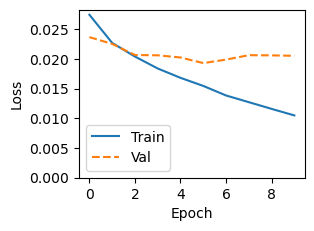

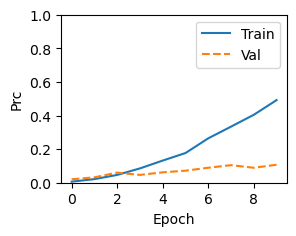

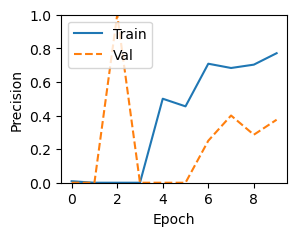

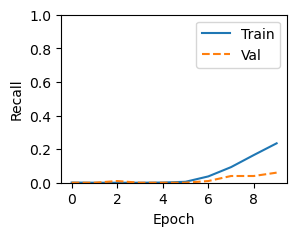

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_' + metric],
              linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    plt.legend()
    plt.show()

plot_metrics(history_basic)

## Weighred product

In [ ]:
# Weighted dot-product
learning_rate = 0.1
loss_list = []
val_list = []

T = tf.Variable(np.ones(X_train_all_ctx.shape[1]//2))

len_train = X_train_all_ctx.shape[0]

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

batch_size = 128
itt = int(np.ceil(len_train/batch_size))

n_epochs = 10

bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

with tqdm(total=itt*n_epochs) as pbar:
    for _ in range(n_epochs):
        for i in range(1,itt+1):
            low = (i-1)*batch_size
            high = min(i*batch_size, len_train)

            a = X_train_all_ctx[low:high,:1536//2]
            b = X_train_all_ctx[low:high,1536//2:]

            y_true = y_train_all_ctx[low:high]
            
            with tf.GradientTape() as tape:
                tape.watch(T)  # Watch the variable T for gradient computation
                W = tf.exp(T)
                y_preds = tf.math.reduce_sum(a*W*b, axis=1)
                error = bce(y_true, y_preds)

            gradients = tape.gradient(error, T)
            optimizer.apply_gradients([(gradients, T)])
            loss_list.append(error.numpy())
            pbar.update(1)
    
        W_val = tf.exp(T)
        y_val_preds = tf.math.reduce_sum(X_val_all_ctx[:,:1536//2].astype(np.float32)*W_val*X_val_all_ctx[:,1536//2:].astype(np.float32), axis=1)
        val_list.append(bce(y_val_all_ctx, y_val_preds).numpy())

loss_list_epochs = []
for i in range(n_epochs):
    loss_list_epochs.append(np.mean(loss_list[i*itt:(i+1)*itt]))

100%|██████████| 17730/17730 [02:42<00:00, 108.95it/s]


In [ ]:
# Save weight information
with open(f'./Results/{embedding_length}/dot_weights', 'wb') as f:
    f.write(pickle.dumps(T))

with open(f'./Results/{embedding_length}/weight_loss', 'wb') as f:
    f.write(pickle.dumps(loss_list_epochs))

with open(f'./Results/{embedding_length}/weight_val', 'wb') as f:
    f.write(pickle.dumps(val_list))

In [ ]:
# Weight predictions
W_test = tf.exp(T)
y_weight_preds = tf.math.reduce_sum(X_test_all_ctx[:,:1536//2].astype(np.float32)*W_test*X_test_all_ctx[:,1536//2:].astype(np.float32), axis=1)

In [ ]:
# Dot predictions
y_dot_preds = [np.dot(a, b) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)
  plt.plot(fp, tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.05,1])
  plt.ylim([0,1.05])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

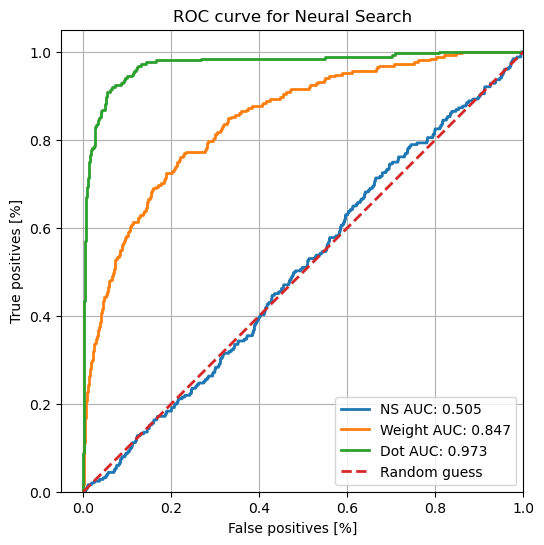

In [ ]:
# Plot ROC curve
plt.figure(figsize=(10,6))
plot_roc("NS", y_test_all_ctx, y_nnb_preds)
plot_roc("Weight", y_test_all_ctx, y_weight_preds)
plot_roc("Dot", y_test_all_ctx, y_dot_preds)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Random guess')
# plt.title("ROC curve for Neural Search")
plt.title(f"ROC curve for Neural Search for {embedding_length} characters for WW2")
plt.legend(loc='lower right')
plt.savefig(f'./Results/{embedding_length}/search_{embedding_length}.png')
plt.show()